## Importing Libraries

In [36]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

## Loading dataset

In [37]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/google-speech-commands/LICENSE
/kaggle/input/google-speech-commands/testing_list.txt
/kaggle/input/google-speech-commands/README.md
/kaggle/input/google-speech-commands/validation_list.txt
/kaggle/input/google-speech-commands/no/97f4c236_nohash_3.wav
/kaggle/input/google-speech-commands/no/6f3458b3_nohash_1.wav
/kaggle/input/google-speech-commands/no/cb2929ce_nohash_3.wav
/kaggle/input/google-speech-commands/no/ad63d93c_nohash_1.wav
/kaggle/input/google-speech-commands/no/aeb99b1c_nohash_1.wav
/kaggle/input/google-speech-commands/no/c08585c1_nohash_4.wav
/kaggle/input/google-speech-commands/no/9d32f10a_nohash_0.wav
/kaggle/input/google-speech-commands/no/01648c51_nohash_1.wav
/kaggle/input/google-speech-commands/no/df1d5024_nohash_2.wav
/kaggle/input/google-speech-commands/no/e0315cf6_nohash_1.wav
/kaggle/input/google-speech-commands/no/28497c5b_nohash_1.wav
/kaggle/input/google-speech-commands/no/c22d3f18_nohash_0.wav
/kaggle/input/google-speech-commands/no/d90b4138_noha

In [38]:
# Define dataset path
dataset_path = "/kaggle/input/google-speech-commands"

categories = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']



In [39]:
for category in categories:
    category_path = os.path.join(dataset_path, category)
    print(f"Path for category '{category}': {category_path}")

Path for category 'zero': /kaggle/input/google-speech-commands/zero
Path for category 'one': /kaggle/input/google-speech-commands/one
Path for category 'two': /kaggle/input/google-speech-commands/two
Path for category 'three': /kaggle/input/google-speech-commands/three
Path for category 'four': /kaggle/input/google-speech-commands/four
Path for category 'five': /kaggle/input/google-speech-commands/five
Path for category 'six': /kaggle/input/google-speech-commands/six
Path for category 'seven': /kaggle/input/google-speech-commands/seven
Path for category 'eight': /kaggle/input/google-speech-commands/eight
Path for category 'nine': /kaggle/input/google-speech-commands/nine


In [40]:
for category in categories:
    category_path = os.path.join(dataset_path, category)
    # Get the list of all .wav files in the category folder
    audio_files = [file for file in os.listdir(category_path) if file.endswith(".wav")]
    print(f"Number of audio files in '{category}': {len(audio_files)}")

Number of audio files in 'zero': 2376
Number of audio files in 'one': 2370
Number of audio files in 'two': 2373
Number of audio files in 'three': 2356
Number of audio files in 'four': 2372
Number of audio files in 'five': 2357
Number of audio files in 'six': 2369
Number of audio files in 'seven': 2377
Number of audio files in 'eight': 2352
Number of audio files in 'nine': 2364


## Feature extraction

In [41]:
X = [] 
y = [] 


In [42]:
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=60)  
    
    mfcc_resized = np.resize(mfcc, (64, 64))  # Resize to (64, 64)
    
    mfcc_resized = mfcc_resized / np.max(np.abs(mfcc_resized))  # Normalize to [0, 1]

    return mfcc_resized

In [43]:
for category in categories:
    category_path = os.path.join(dataset_path, category)
    audio_files = [f for f in os.listdir(category_path) if f.endswith(".wav")]

    for audio_file in audio_files:
        file_path = os.path.join(category_path, audio_file)
        features = extract_features(file_path)
        X.append(features)
        y.append(category)


In [44]:
X = np.array(X)
y = np.array(y)

In [45]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


## Data preprocessing

In [46]:
# Reshape X for ANN input 
X = X.reshape(X.shape[0], 64*64)

In [47]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [48]:
# Normalize features
X_train = X_train / 255.0  # Normalize pixel values to be between 0 and 1
X_test = X_test / 255.0


##  ANN model

In [49]:
#Build the model
model = models.Sequential([
    layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),  # Increased number of neurons
    layers.BatchNormalization(),
    layers.Dropout(0.6),  # Increased dropout

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.6),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(len(categories), activation='softmax')  # Output layer
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [51]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [52]:
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,901,194 (18.70 MB)

 Trainable params: 4,897,226 (18.68 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [53]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler])

Epoch 1/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.1358 - loss: 2.8637 - val_accuracy: 0.3352 - val_loss: 1.9084 - learning_rate: 0.0010
Epoch 2/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3117 - loss: 1.9047 - val_accuracy: 0.5068 - val_loss: 1.3879 - learning_rate: 0.0010
Epoch 3/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4302 - loss: 1.6083 - val_accuracy: 0.4630 - val_loss: 1.4762 - learning_rate: 0.0010
Epoch 4/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4734 - loss: 1.4869 - val_accuracy: 0.5537 - val_loss: 1.2525 - learning_rate: 0.0010
Epoch 5/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5214 - loss: 1.3853 - val_accuracy: 0.6244 - val_loss: 1.0423 - learning_rate: 0.0010
Epoch 6/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5501 - loss: 1.2954 - val_accuracy: 0.6278 - val_loss: 1.0423 - learning_rate: 0.0010
Epoch 7/50
592/592 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5776 - loss: 1.2401 

## Model Evaluation

In [54]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8552 - loss: 0.4485
Test accuracy: 85.02%


In [55]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [56]:
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       eight       0.88      0.86      0.87       481
        five       0.86      0.80      0.83       471
        four       0.87      0.85      0.86       454
        nine       0.83      0.83      0.83       487
         one       0.75      0.84      0.80       524
       seven       0.84      0.88      0.86       479
         six       0.92      0.89      0.91       498
       three       0.82      0.84      0.83       444
         two       0.81      0.82      0.81       450
        zero       0.94      0.88      0.91       446

    accuracy                           0.85      4734
   macro avg       0.85      0.85      0.85      4734
weighted avg       0.85      0.85      0.85      4734



In [57]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:\n", report)


148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

       eight       0.88      0.86      0.87       481
        five       0.86      0.80      0.83       471
        four       0.87      0.85      0.86       454
        nine       0.83      0.83      0.83       487
         one       0.75      0.84      0.80       524
       seven       0.84      0.88      0.86       479
         six       0.92      0.89      0.91       498
       three       0.82      0.84      0.83       444
         two       0.81      0.82      0.81       450
        zero       0.94      0.88      0.91       446

    accuracy                           0.85      4734
   macro avg       0.85      0.85      0.85      4734
weighted avg       0.85      0.85      0.85      4734



## Visualization

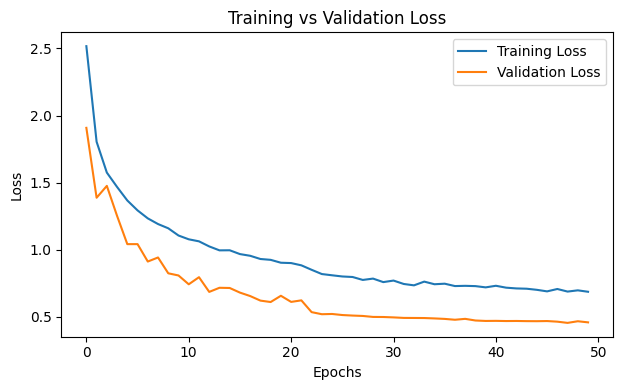

In [58]:
# Visualizing the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

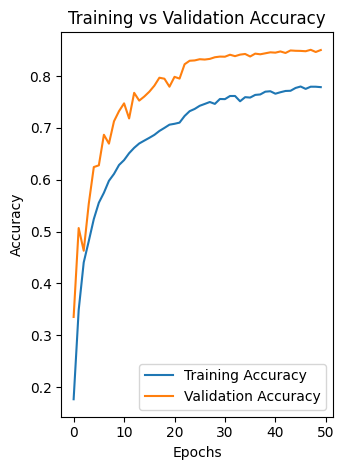

In [59]:
# Visualizing the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()